In this lab will apply linear regression to the California Housing data set to predict house prices using Apache Spark.

Note: This is actually 'small' data and that using Spark in this context is a bit overkill, but transferable to very large datasets.

1. The Data Set

- The California Housing data set appeared in a 1997 paper titled Sparse Spatial Autoregressions, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. The researchers built this data set by using the 1990 California census data. Wouldn't you like to buy a house in California for 1990's prices?

- The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

This spatial data contain 20,640 observations on housing prices with 9 economic variables:

- Longitude: refers to the angular distance of a geographic place north or south of the earth’s equator for each block group
- Latitude: refers to the angular distance of a geographic place east or west of the earth’s equator for each block group
- Housing Median Age: is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
- Total Rooms: is the total number of rooms in the houses per block group
- Total Bedrooms: is the total number of bedrooms in the houses per block group
- Population: is the number of inhabitants of a block group
- Households: refers to units of houses and their occupants per block group
- Median Income: is used to register the median income of people that belong to a block group
- Median House Value: is the dependent variable and refers to the median house value per block group
- The Median house value is the dependent variable and will be assigned the role of the target variable that we are trying to predict in our ML model.

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [5]:
# Create Spark session
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()


In [6]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

In [8]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [9]:
HOUSING_DATA = 'housing.csv'

# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()

In [13]:
# take() and show() are different. 
# show() prints results, take() returns a list of rows (in PySpark) and can be used to create a new dataframe.
# They are both actions.

# Using Take
housing_df.take(5)

# Using show
housing_df.show(5)

# show columns
print("DataFrame columns:")
print(housing_df.columns)

# Show DataFrame schema
print("DataFrame schema:")
housing_df.printSchema()

[Row(long=None, lat=None, medage=None, totrooms=None, totbdrms=None, pop=None, houshlds=None, medinc=None, medhv=None),
 Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0)]

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|   NULL| NULL|  NULL|    NULL|    NULL|  NULL|    NULL|  NULL|    NULL|
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows

DataFrame columns:
['long', 'lat', 'medage', 'totrooms', 'totbdrms', 'pop', 'houshlds', 'medinc', 'medhv']
DataFrame schema:
root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |--

In [14]:
# Data Exploration 
housing_df.select('pop','totbdrms').show(10)


+------+--------+
|   pop|totbdrms|
+------+--------+
|  NULL|    NULL|
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
+------+--------+
only showing top 10 rows



In [15]:
# Prepare for PySpark SQL usage

housing_df.createOrReplaceTempView("HOUSING")

housing_df_sql = spark.sql("SELECT pop, totbdrms from HOUSING")
housing_df_sql.printSchema()

root
 |-- pop: float (nullable = true)
 |-- totbdrms: float (nullable = true)



+----------+-----+
|Median_Age|Count|
+----------+-----+
|      52.0| 1273|
|      51.0|   48|
|      50.0|  136|
|      49.0|  134|
|      48.0|  177|
|      47.0|  198|
|      46.0|  245|
|      45.0|  294|
|      44.0|  356|
|      43.0|  353|
|      42.0|  368|
|      41.0|  296|
|      40.0|  304|
|      39.0|  369|
|      38.0|  394|
|      37.0|  537|
|      36.0|  862|
|      35.0|  824|
|      34.0|  689|
|      33.0|  615|
+----------+-----+
only showing top 20 rows

CodeCache: size=131072Kb used=29747Kb max_used=29769Kb free=101324Kb
 bounds [0x000000010b18c000, 0x000000010cecc000, 0x000000011318c000]
 total_blobs=11648 nmethods=10662 adapters=898
 compilation: disabled (not enough contiguous free space left)


OpenJDK 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


<BarContainer object of 53 artists>

Text(0.5, 0, 'Median Age')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Histogram of Median Age')

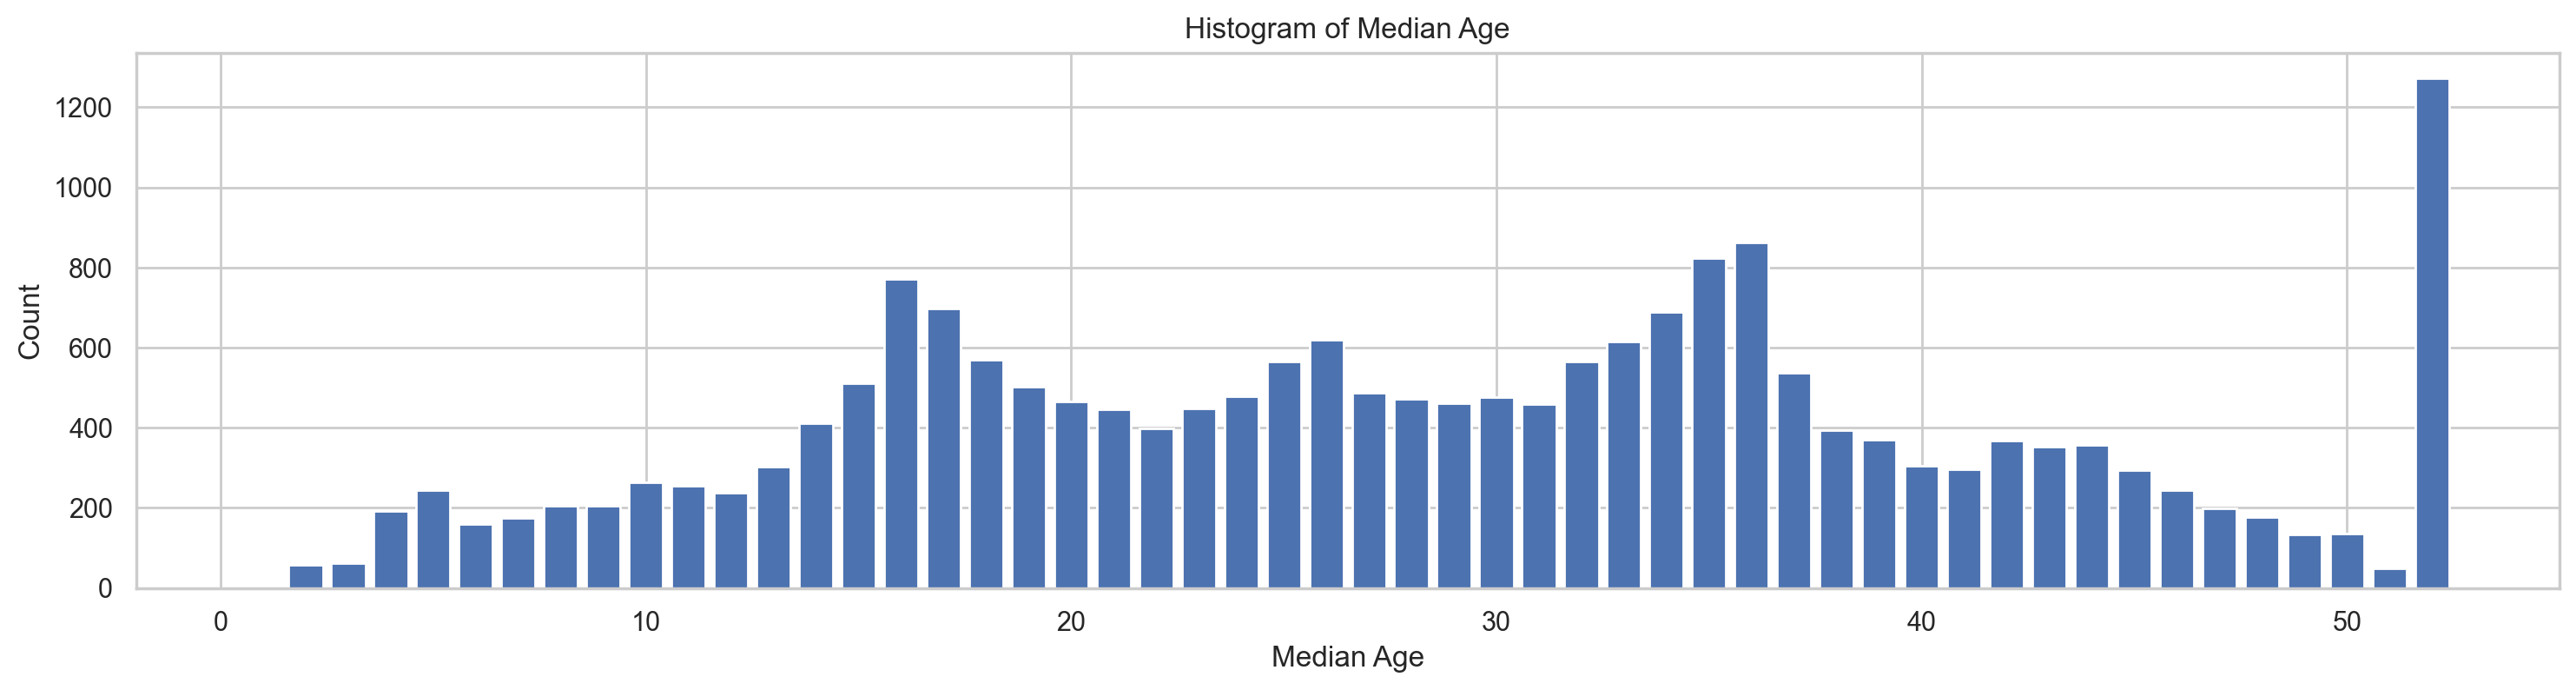

In [18]:
import matplotlib.pyplot as plt

# Using PySpark SQL & MatPlotLib

histogram_query = """
SELECT medage AS Median_Age, COUNT(*) AS Count
FROM HOUSING
GROUP BY medage
ORDER BY medage DESC
"""

# Execute the query
age_histogram_df = spark.sql(histogram_query)

# Show the results
age_histogram_df.show()

# Convert to Pandas DataFrame for visualization
pandas_df = age_histogram_df.toPandas()

# Plotting the histogram
plt.bar(pandas_df['Median_Age'], pandas_df['Count'])
plt.xlabel('Median Age')
plt.ylabel('Count')
plt.title('Histogram of Median Age')
plt.show()

4.2 Summary Statistics
- In Spark you can use df.describe() or df.summary() to review statistical information for numerical columns.
- The difference is that df.summary() returns the same information as df.describe() plus quartile information (25%, 50% and 75%).

In [19]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

24/05/02 04:56:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20433.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631|537.8706|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.3851|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



In [20]:
(housing_df.summary().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20433.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631|537.8706|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.3851|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    25%|   18.0|   1447.0|   296.0|    787.0|   280.0| 2.5625|   119600.0|
|    50%|   29.0|   2127.0|   435.0|   1166.0|   409.0| 3.5347|   179700.0|
|    75%|   37.0|   3146.0|   647.0|   1724.0|   605.0| 4.7426|   264700.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



5. Data Preprocessing
- We shouldn't need to care about missing values; all zero values have been excluded from the data set.
- We should definitely standardize our data, as we have seen that the range of minimum and maximum values is quite big.
- There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
- Our dependent variable is also quite large. To make our life easier, we'll have to adjust the values

5.1 Preprocessing The Target Values
- medianHouseValue is our dependent variable (target). To make things a little easier we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526:

In [21]:
# Adjust the values of median house value
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

In [22]:
# Show the first 2 lines of `df`
housing_df.show(2)

+-------+-----+------+--------+--------+-----+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|  pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+-----+--------+------+-----+
|   NULL| NULL|  NULL|    NULL|    NULL| NULL|    NULL|  NULL| NULL|
|-122.23|37.88|  41.0|   880.0|   129.0|322.0|   126.0|8.3252|4.526|
+-------+-----+------+--------+--------+-----+--------+------+-----+
only showing top 2 rows



6. Feature Engineering
- Now that we have adjusted the values for medhv, we will add the following columns to the data set:

- Rooms per household which refers to the number of rooms in households per block group. totrooms/houshlds
Population per household, which basically gives us an indication of how many people live in households per block group. pop/houshlds
- Bedrooms per total rooms which will give us an idea about how many rooms are bedrooms per block group. totbdrms/totrooms
We can add columns to a DataFrame based on another existing column value using df.withColumn



In [23]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [25]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# Inspect the result
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   NULL| NULL|  NULL|    NULL|    NULL|  NULL|    NULL|  NULL| NULL|    NULL|    NULL|      NULL|
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



Looking at the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.6 people and the amount of bedrooms is quite low with 0.15:

- Since we don't want to standardize our target values, we need to isolate the target value in our data set.

- Note: this is also the time to leave out variables that we might not want to consider in our analysis. Let's leave out variables such as longitude, latitude, housingMedianAge and totalRooms.

- In this case, we will use the select() method and pass the column names in an order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won't be affected by the standardization.

In [26]:
# Select and order the columns as specified
housing_df = housing_df.select(
    "medhv",
    "totbdrms",
    "pop",
    "houshlds",
    "medinc",
    "rmsperhh",
    "popperhh",
    "bdrmsperrm"
)

# Show the resulting DataFrame with the new column order
housing_df.show()

+-----+--------+------+--------+------+--------+--------+----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|
+-----+--------+------+--------+------+--------+--------+----------+
| NULL|    NULL|  NULL|    NULL|  NULL|    NULL|    NULL|      NULL|
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|
|3.521|   190.0| 496.0|   177.0|7.2574|    8.29|     2.8|      0.13|
|3.413|   235.0| 558.0|   219.0|5.6431|    5.82|    2.55|      0.18|
|3.422|   280.0| 565.0|   259.0|3.8462|    6.28|    2.18|      0.17|
|2.697|   213.0| 413.0|   193.0|4.0368|    4.76|    2.14|      0.23|
|2.992|   489.0|1094.0|   514.0|3.6591|    4.93|    2.13|      0.19|
|2.414|   687.0|1157.0|   647.0|  3.12|     4.8|    1.79|      0.22|
|2.267|   665.0|1206.0|   595.0|2.0804|    4.29|    2.03|      0.26|
|2.611|   707.0|1551.0|   714.0|3.6912|    4.97|    2.17|       0.2|
|2.815|   434.0| 910.0|   402.0|3.

6.1 Feature Extraction
- Now that we have re-ordered the data, we're ready to normalize the data. Choose the features to be normalized.

In [27]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]


In [29]:
# Remove Nulls
housing_df = housing_df.dropna(how="any")

# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

assembled_df = assembler.transform(housing_df)

assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


6.2 Standardization
- We can now scale the data using StandardScaler. The input columns are the features, and the output column are rescaled features that we will be include in the scaled_df named "features_scaled":

In [30]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [31]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [32]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.306133295081709,0.2841489478008318,0.329584763633844,4.383319347393149,2.8111579992311904,0.245252327599291,2.584777863821999]     |
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6246777082199237,2.1187628064279416,2.976725881073924,4.370788411842967,2.5131269219488006,0.20214156688847812,2.7570963880767994] |
|[190.0,496.0,177.0,7.2574000358581

7. Building A Machine Learning Model With Spark ML

- With preprocessing done, we can finally build the Linear Regression model.
- First, split the data into training and test sets using randomSplit():
- Pass in a list with two numbers that represent the size that we want your training and test sets to have and a seed, which is needed for reproducibility reasons.

In [33]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

In [34]:
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

Create an ElasticNet model:

- ElasticNet is a linear regression model trained with L1 and L2 prior as a regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge regression. We can control the convex combination of L1 and L2 using the l1_ratio parameter.

- Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

- A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

In [35]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [36]:
# Fit the data to the model
linearModel = lr.fit(train_data)

24/05/02 05:07:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


8. Evaluating the Model
- With our model in place, we can generate predictions for our test data.

- We can use the transform() method to predict the labels for the test_data. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame.

In [37]:
# Coefficients for the model
linearModel.coefficients

featureCols

# Intercept for the model
linearModel.intercept

coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

coeff_df

DenseVector([0.0, 0.0, 0.0, 0.5321, 0.0, 0.0, 0.0])

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

0.9886301769776031

,Feature,Co-efficients
0,Intercept,0.988630
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.532102
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


Inspect the coefficients. Which independent variable is most predictive?

- Come up with a working hypothesis for why you think this is true

- The largest coefficent is the median income. My hypothesis is that it's the largest predictor because having money is pre-requisite to buying a property and those with higher incomes tend to buy properties.

In [40]:
# Generate predictions
predictions = linearModel.transform(test_data)

# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")

predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
| 1.138795110285149|0.14999|
|1.2945071662747933|  0.225|
|1.7489241674075027|  0.225|
|1.6037180266005446|  0.269|
|1.5897942123047901|  0.344|
|1.2824043167165895|  0.367|
|1.8641253353674527|  0.375|
|1.3609327363749197|  0.394|
|1.5239289184946858|  0.398|
|1.5653643492363898|  0.409|
| 1.317199992497681|  0.417|
|1.2198169364407725|  0.425|
|1.4770023726613912|  0.425|
|1.3423302343260983|   0.43|
|1.2521752300138238|  0.436|
|1.3261931015818265|   0.44|
|1.4761058838408705|   0.44|
|1.4259855360515208|  0.444|
|1.3606245777359096|  0.445|
|1.4679532559867374|  0.446|
+------------------+-------+
only showing top 20 rows



8.3 Inspect the Metrics
- We need to calculate some metrics to get a better idea of how good your model actually is.

In [41]:
# Initialize evaluators for RMSE, MAE, and R2
rmse_evaluator = RegressionEvaluator(labelCol="medhv", predictionCol="predmedhv", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="medhv", predictionCol="predmedhv", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="medhv", predictionCol="predmedhv", metricName="r2")

# Calculate RMSE, MAE, and R2
rmse = rmse_evaluator.evaluate(predandlabels)
mae = mae_evaluator.evaluate(predandlabels)
r2 = r2_evaluator.evaluate(predandlabels)

# Print the results
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R^2: ", r2)

RMSE:  0.8747210883194528
MAE:  0.6754015223732088
R^2:  0.4144337498792193
